# Бинарная классификация исхода гражданского процесса

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp

%matplotlib inline
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('tmp/civil_court_orders_to_classifier.csv.gz', compression='gzip') 
df.loc[:, ['vectors', 'pca', 'money', 'descr_articles']] = df.loc[:, ['vectors', 'pca', 'money', 'descr_articles']].applymap(eval)

In [3]:
df['result'].unique()

array(['Иск (заявление, жалоба) УДОВЛЕТВОРЕН',
       'Производство по делу ПРЕКРАЩЕНО',
       'ОТКАЗАНО в удовлетворении иска (заявлении, жалобы)',
       'Иск (заявление, жалоба) ОСТАВЛЕН БЕЗ РАССМОТРЕНИЯ',
       'Заявление ВОЗВРАЩЕНО заявителю',
       'Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО',
       'Передано по подсудности, подведомственности',
       'Производство по делу ПРЕКРАЩЕНО (ст.220 ГПК)',
       'ОТКАЗАНО в принятии заявления',
       'Дело присоединено к другому делу'], dtype=object)

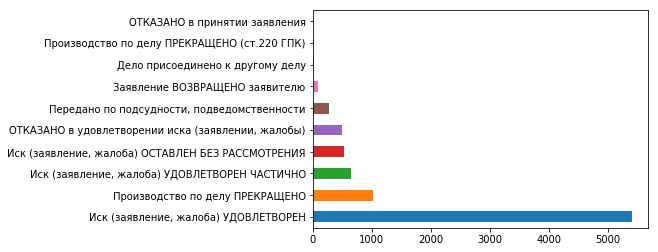

In [4]:
df['result'].value_counts().plot(kind='barh')
plt.show()

Иск _УДОВЛЕТВОРЕН_ vs все остальное

In [5]:
df['satisfied_or_not'] = df['result'].map(lambda x: 1 if "Иск (заявление, жалоба) УДОВЛЕТВОРЕН" in x else 0)

In [6]:
def kfold_auc(classifier, X, y, cv = StratifiedKFold(n_splits=6)):
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300)
    for i, (train, test) in enumerate(cv.split(X, y)):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold {} (AUC = {:.2f})'.format(i, roc_auc))
        i += 1
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=.8,
             label=r'Mean ROC (AUC = {:.2f} $\pm$ {:.2f})'.format(mean_auc, std_auc))
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    return ax

In [7]:
X = np.array(df['vectors'].tolist())
y = np.array(df['satisfied_or_not'])

In [8]:
svc = SVC(kernel='rbf', probability=True, random_state=42)

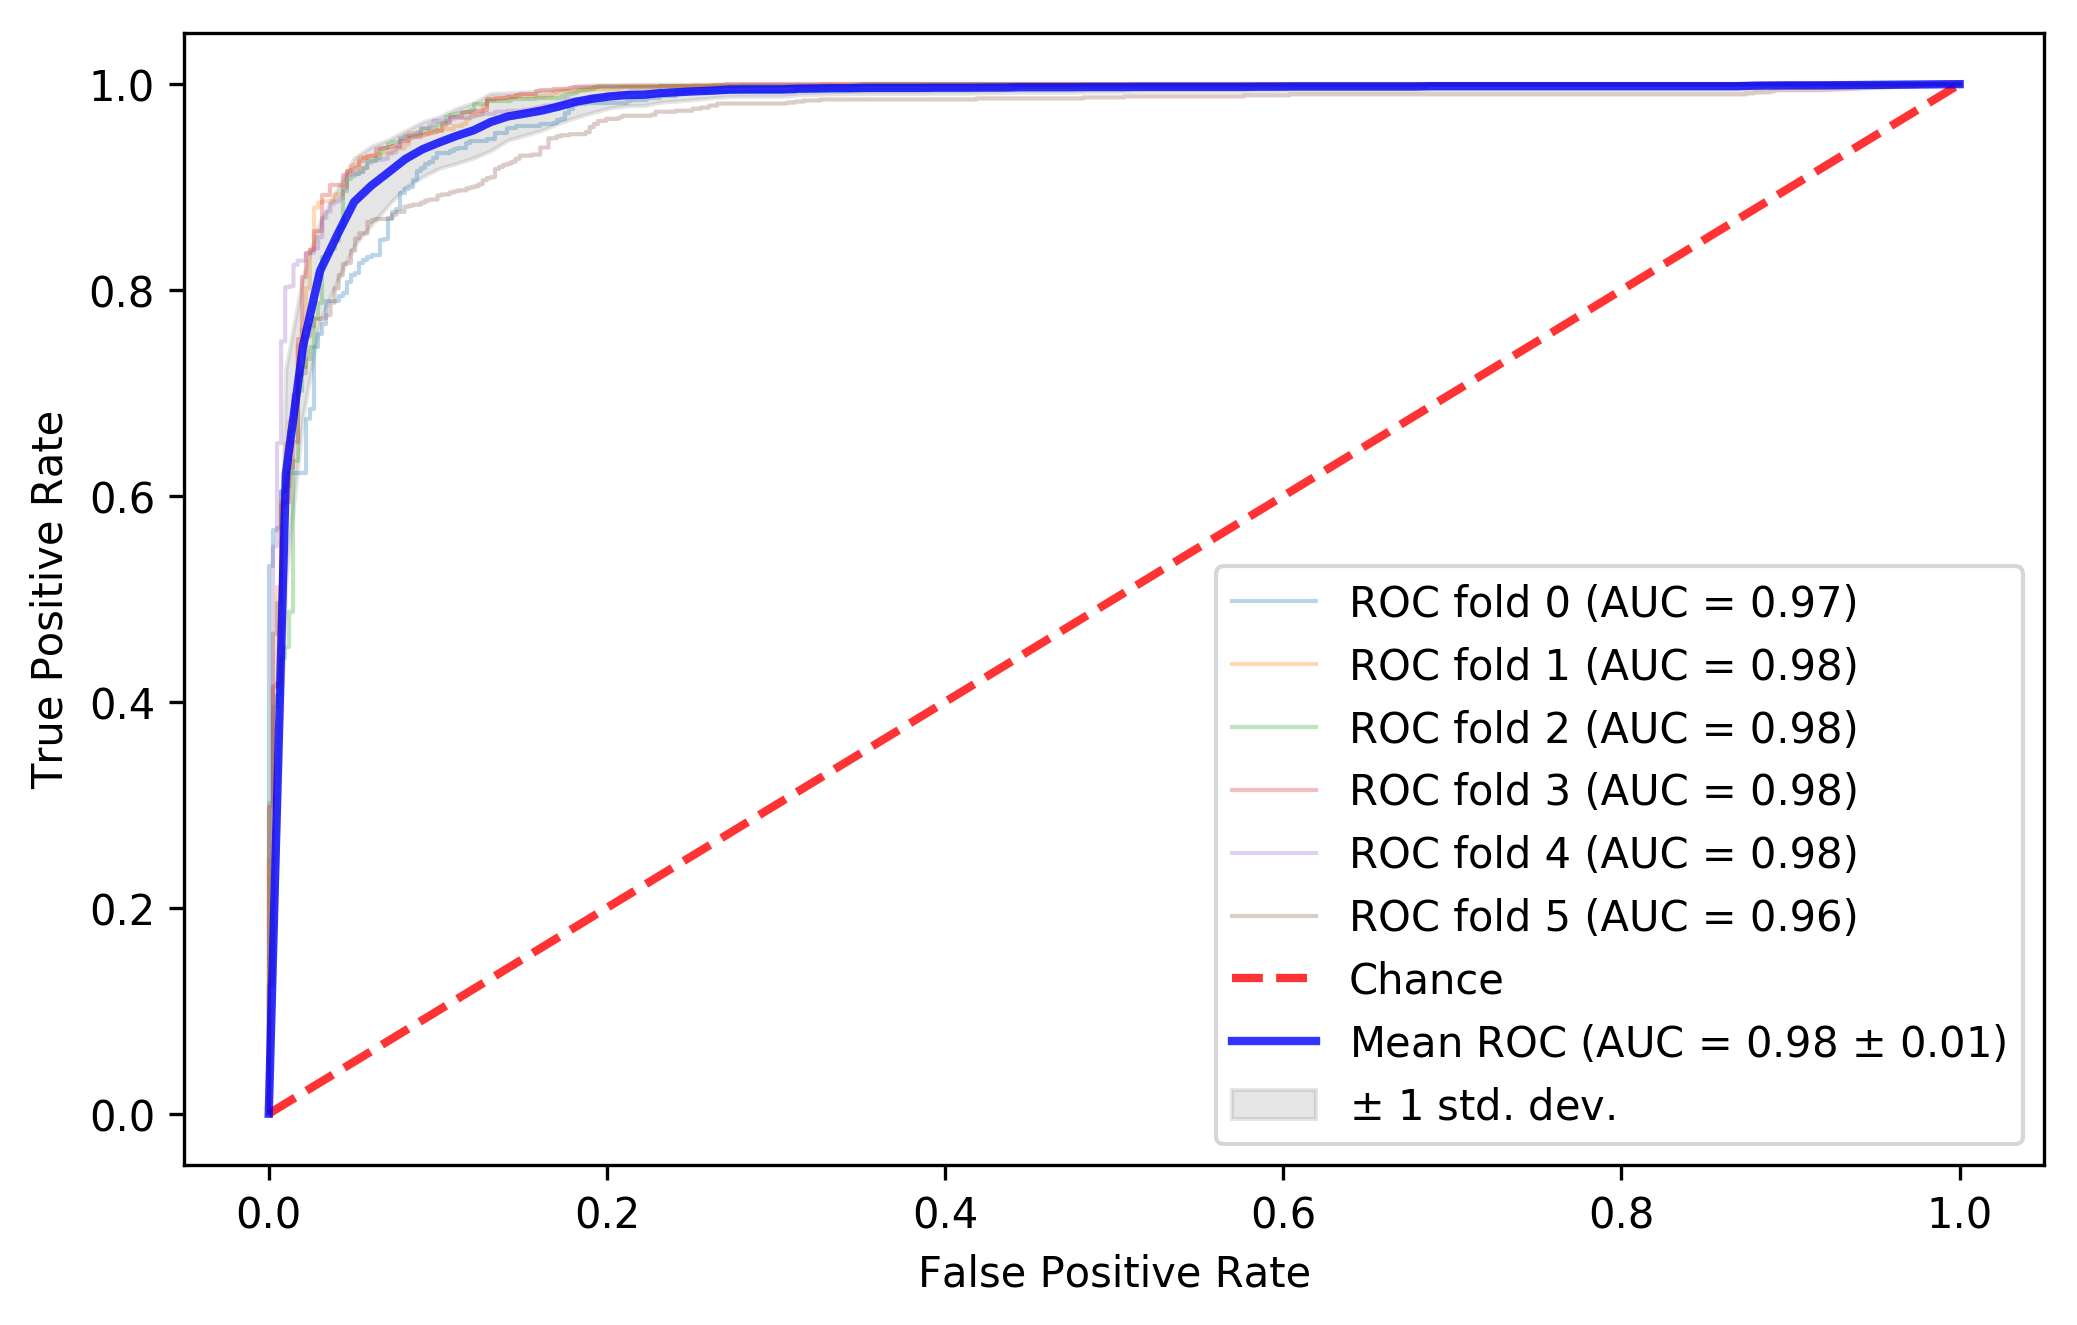

In [ ]:
kfold_auc(svc, X, y)